In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image as PILImage
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.models.segmentation import fcn_resnet50


The data is only included in the drive submission

https://www.kaggle.com/datasets/devdgohil/the-oxfordiiit-pet-dataset/data


In [46]:
images_dir = './images'
trimaps_dir = './annotations/trimaps'

to_remove = [
    "Egyptian_Mau_14", "Egyptian_Mau_139", "Egyptian_Mau_145", "Egyptian_Mau_156",
    "Egyptian_Mau_167", "Egyptian_Mau_177", "Egyptian_Mau_186", "Egyptian_Mau_191",
    "Abyssinian_5", "Abyssinian_34",
    "chihuahua_121", "beagle_116"
]

removed = []
not_found = []

for base_name in to_remove:
    img_path = os.path.join(images_dir, base_name + ".jpg")
    mask_path = os.path.join(trimaps_dir, base_name + ".png")

    for path in [img_path, mask_path]:
        try:
            if os.path.exists(path):
                os.remove(path)
                removed.append(path)
            else:
                not_found.append(path)
        except Exception as e:
            print(f"1")


In [47]:
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, trimaps_dir, transform=None, image_size=(224, 224)):
        self.images_dir = os.path.normpath(images_dir)
        self.trimaps_dir = os.path.normpath(trimaps_dir)
        self.transform = transform
        self.image_size = image_size

        self.image_filenames = sorted([
            f for f in os.listdir(self.images_dir)
            if f.endswith('.jpg') and os.path.exists(os.path.join(self.trimaps_dir, f.replace('.jpg', '.png')))
        ])

        if len(self.image_filenames) == 0:
            raise RuntimeError("1")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        mask_filename = image_filename.replace('.jpg', '.png')

        image_path = os.path.normpath(os.path.join(self.images_dir, image_filename))
        mask_path = os.path.normpath(os.path.join(self.trimaps_dir, mask_filename))

        
        image = cv2.imread(image_path)
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        new_mask = np.full_like(mask, 255)
        new_mask[mask == 1] = 1
        new_mask[mask == 2] = 0

        image = PILImage.fromarray(image).resize(self.image_size, PILImage.BILINEAR)
        new_mask = PILImage.fromarray(new_mask).resize(self.image_size, PILImage.NEAREST)

        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        mask_tensor = T.ToTensor()(new_mask).squeeze(0).long()

        return image, mask_tensor


transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

images_dir = './images'
trimaps_dir = './annotations/trimaps'

dataset = OxfordPetsDataset(images_dir, trimaps_dir, transform=transform)

In [48]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)  # 2 classes: background, pet
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

c:\Users\HUA\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HUA\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for input, labels in train_loader:
        input = input.to(device)
        labels = labels.to(device)

        outputs = model(input)['out']
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/10, Loss: 133.0546
Epoch 2/10, Loss: 102.8726
Epoch 3/10, Loss: 94.1568
Epoch 4/10, Loss: 87.1320
Epoch 5/10, Loss: 81.6391
Epoch 6/10, Loss: 76.8578
Epoch 7/10, Loss: 71.6799
Epoch 8/10, Loss: 67.4184
Epoch 9/10, Loss: 64.0444
Epoch 10/10, Loss: 59.8990


In [ ]:
torch.save(model, 'fcn_pet_full.pth')


In [49]:
model = torch.load('fcn_pet_full.pth', map_location=device)
model.eval()


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

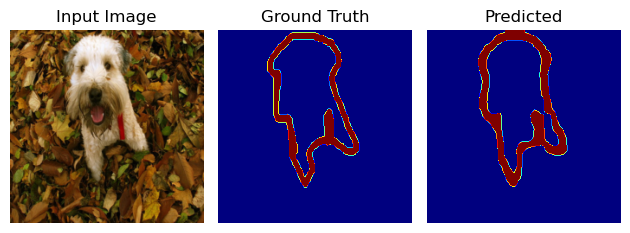

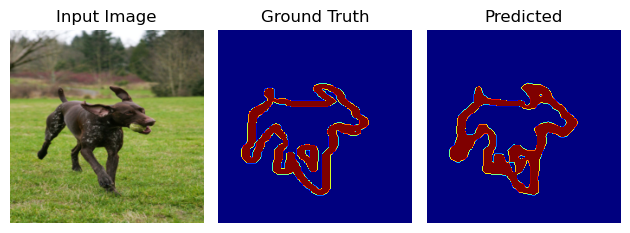

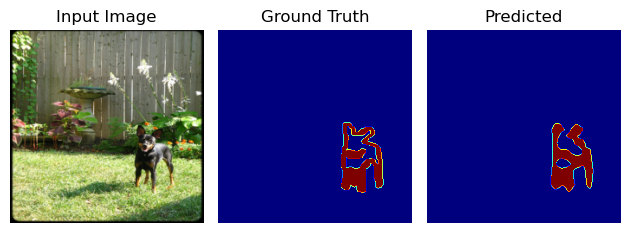

In [50]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    outputs = model(images)['out']
    preds = torch.argmax(outputs, dim=1).cpu()


for i in range(3):
    image = images[i].cpu().permute(1, 2, 0).numpy()
    image = np.clip(image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

    mask = masks[i].cpu().numpy()
    pred = preds[i].numpy()

    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[1].imshow(mask, cmap='jet', vmin=0, vmax=1)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred, cmap='jet', vmin=0, vmax=1)
    axs[2].set_title("Predicted")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [57]:
img_path = "./cow-test.jpg"
image = PILImage.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

In [58]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)['out']
    pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()


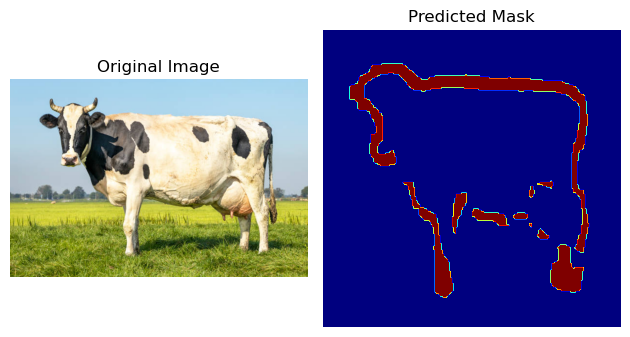

In [59]:
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=1)
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
